# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моём распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель:** нужно построить модель для определения стоимости автомобиля

**Заказчику важны:**
1. качество предсказания;
2. скорость предсказания;
3. время обучения.

## Подготовка данных

###  Загрузка и первое знакомство

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import make_scorer, mean_squared_error

import time

In [2]:
data = pd.read_csv('11.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Имеем 16 колонок, 354369 строк. Типы данных object и int64. Заметно большое количество пропусков.

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описательные статистики отображают много аномалий: есть лоты с нулевой ценой, лоты, зарегестрированные в 1000 году, в 9999 году, или в 0 месяце, лоты с мощностью 0 л.с. и 20000 лошадиных сил, а столбец с количеством картинок полностью нулевой - очевидно, что всё это аномалии, от которых нужно избавляться.

### Предобработка

Залог успешной предобработки - план. Начнем с него:
1. Заполнение пропусков
2. Кодирование
3. Поиск выбросов и аномалий 
4. Масштабирование
5. Проверка на корреляцию
6. Отбор признаков
7. Удаление дубликатов

#### Заполнение/удаление пропусков

- Столбец **тип кузова:**

In [5]:
data.VehicleType.isna().sum() / data.shape[0] * 100

10.57936783409384

Количество пропусков в столбце VehicleType составляет 10 процентов от общего числа объектов в датафрейме. Заполним пропуски заглушкой

In [6]:
data.VehicleType = data.VehicleType.fillna('other')

- Столбец **коробка передач:**

In [7]:
data.Gearbox.value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Можно считать, что если в столбце пропуск, то скорее всего коробка ручная, поэтому пропуски заполним значением manual

In [8]:
data.Gearbox = data.Gearbox.fillna('manual')

- Столбец **модель** по аналогии с типом кузова заполним заглушками

In [9]:
data.Model = data.Model.fillna('other')

- Столбец **тип топлива:**

In [10]:
data.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Заполним пропуски значением other

In [11]:
data.FuelType = data.FuelType.fillna('other')

- Столбец, отображающий **наличие ремонта**. Здесь пропуски будет логично прировнять к отсутствию ремонта

In [12]:
data.Repaired = data.Repaired.fillna('no')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Итог**

Пропусков больше нет

#### Обработка аномалий 

- Столбец с **ценой**

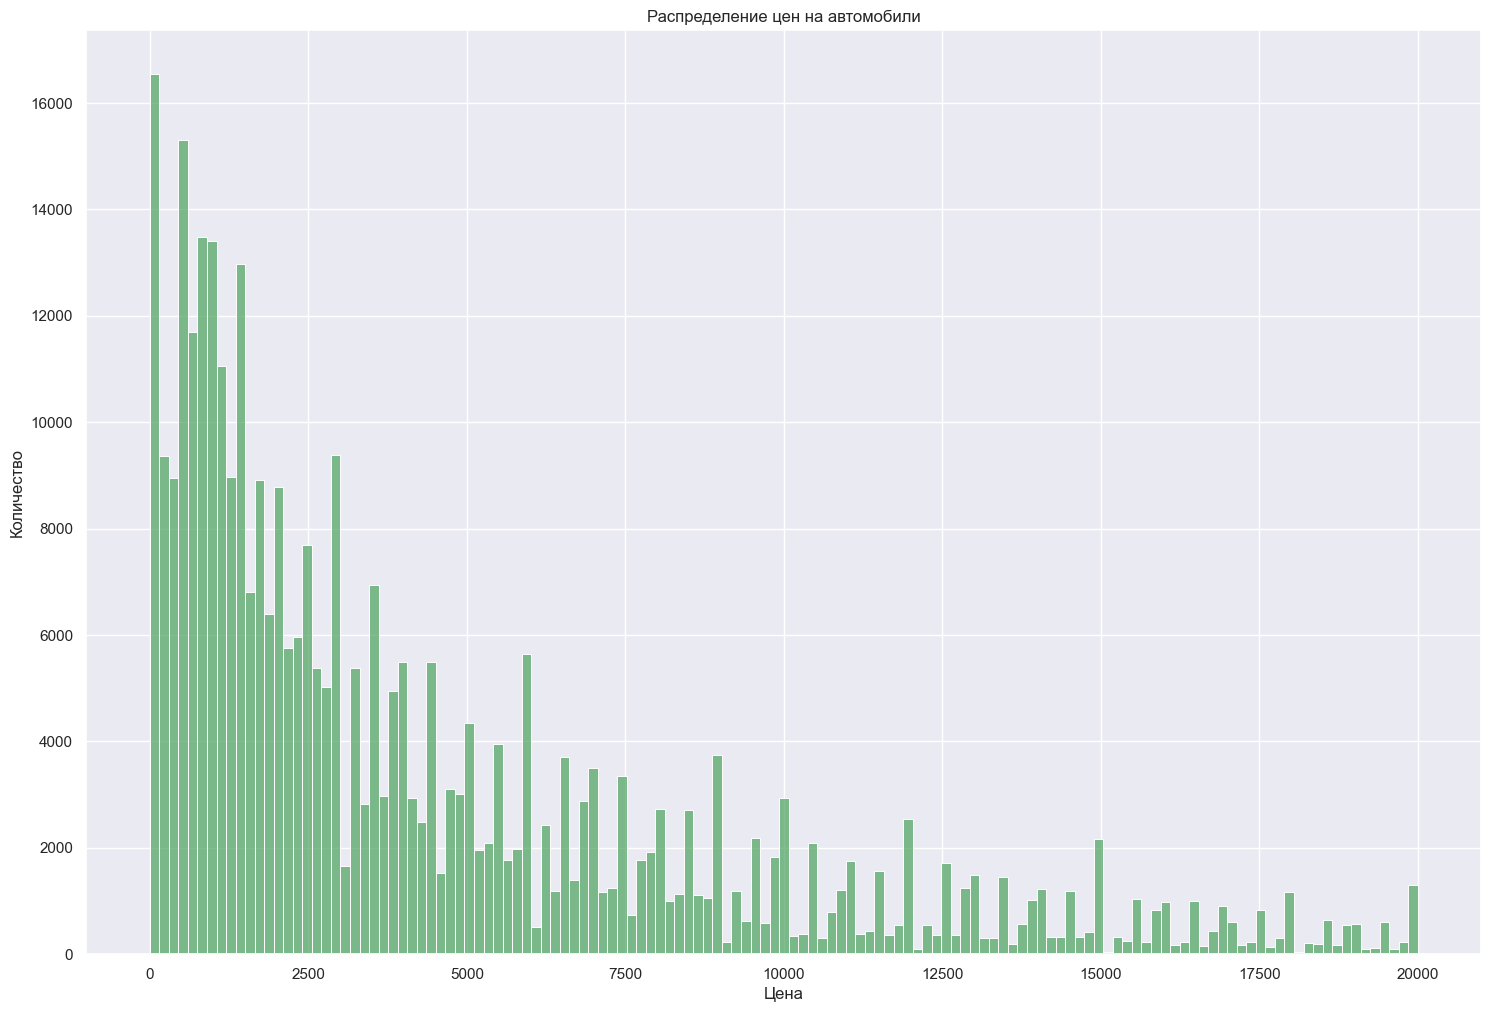

In [15]:
sns.set(rc={"figure.figsize": (18, 12)})
sns.histplot(data.Price, color='g').set(title='Распределение цен на автомобили', xlabel='Цена', ylabel='Количество');

На графике распредления видно большое скопление объектов с нулевой ценой. Это явно выброс, от них нужно избавляться. Удалим все объекты с ценой ниже 100.

In [16]:
data = data[data['Price'] > 100]

<div class="alert alert-block alert-info">
<b>Совет:</b>   Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>


- Столбец с **годом регистрации**

In [17]:
data.RegistrationYear.value_counts()

2000    22496
1999    21780
2005    21341
2006    19639
2001    19550
        ...  
3700        1
3800        1
4800        1
2290        1
1946        1
Name: RegistrationYear, Length: 136, dtype: int64

Видно, что имеются аномальные значения года, поэтому ограничим год регистрации с 1950 по 2017

In [18]:
data = data[(1949 < data['RegistrationYear']) & (data['RegistrationYear'] < 2017)]

- Столбец **мощности**

Мощность автомобиля сверху ограничена 1000 л.с. по данным Google.

In [19]:
data = data[data['Power'] < 1000]

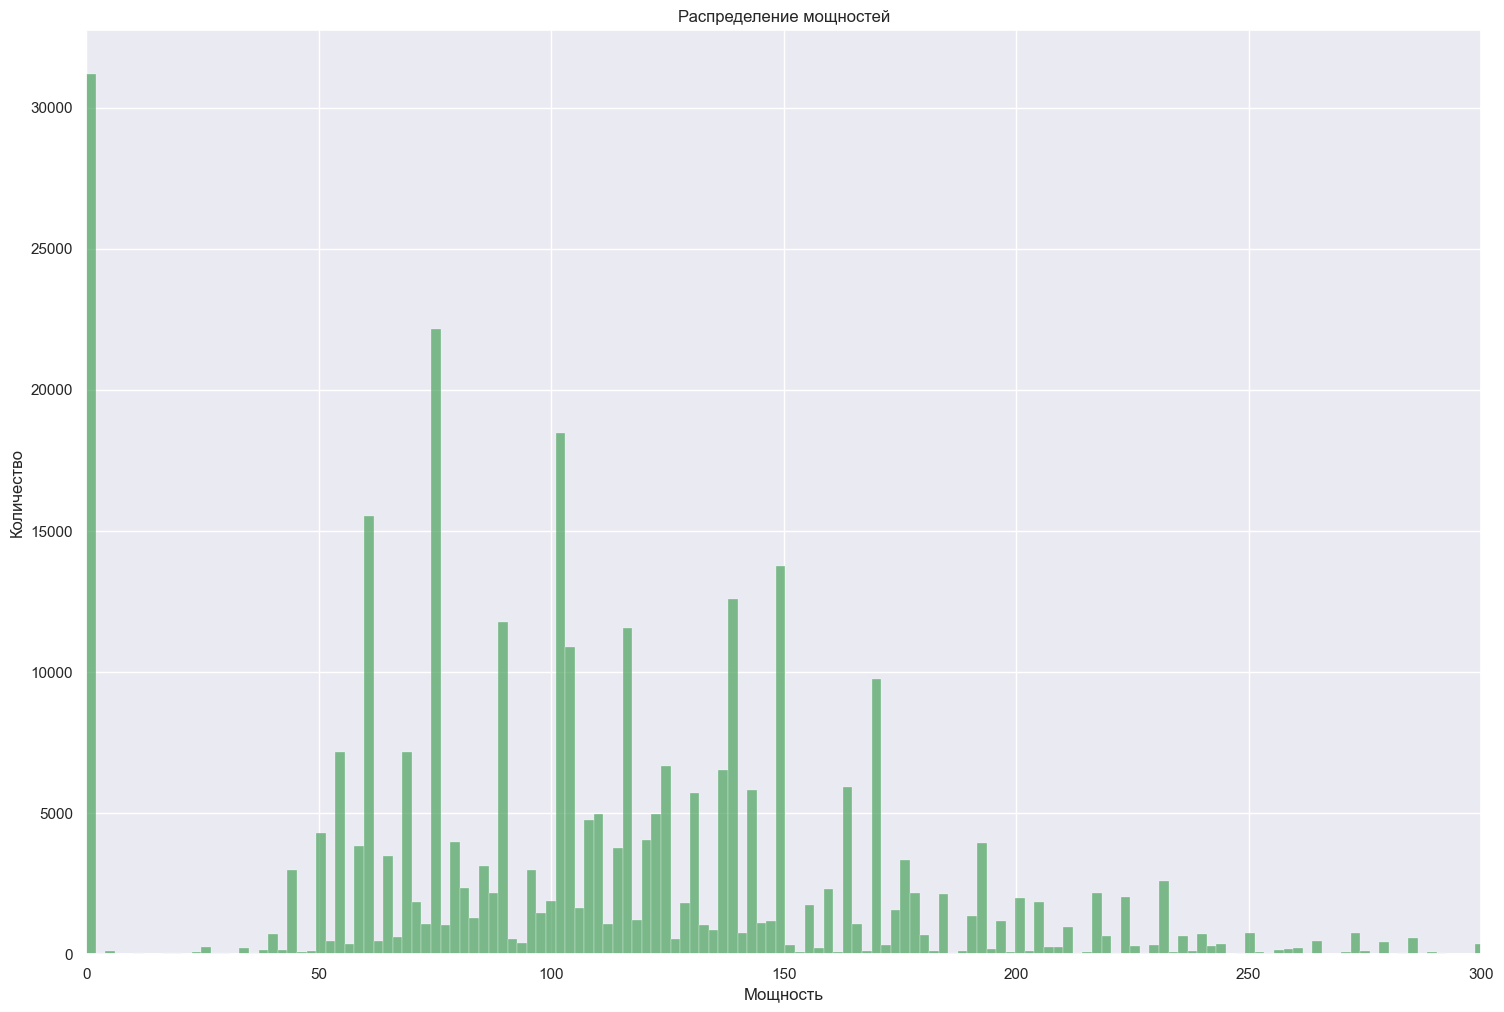

In [21]:
sns.set(rc={"figure.figsize": (18, 12)})
sns.histplot(data.Power, color='g').set(title='Распределение мощностей', xlabel='Мощность', ylabel='Количество', xlim=(0, 300));


Виден огромный выброс около 0. Так как восстановить мощность по другим признакам не предсатвляется возможным, то удалим этот выброс. Также будем считать выбросами все объекты, шде лошадиных сил менее 10

In [23]:
data = data[data['Power'] > 9]

- Столбец с **километражом**

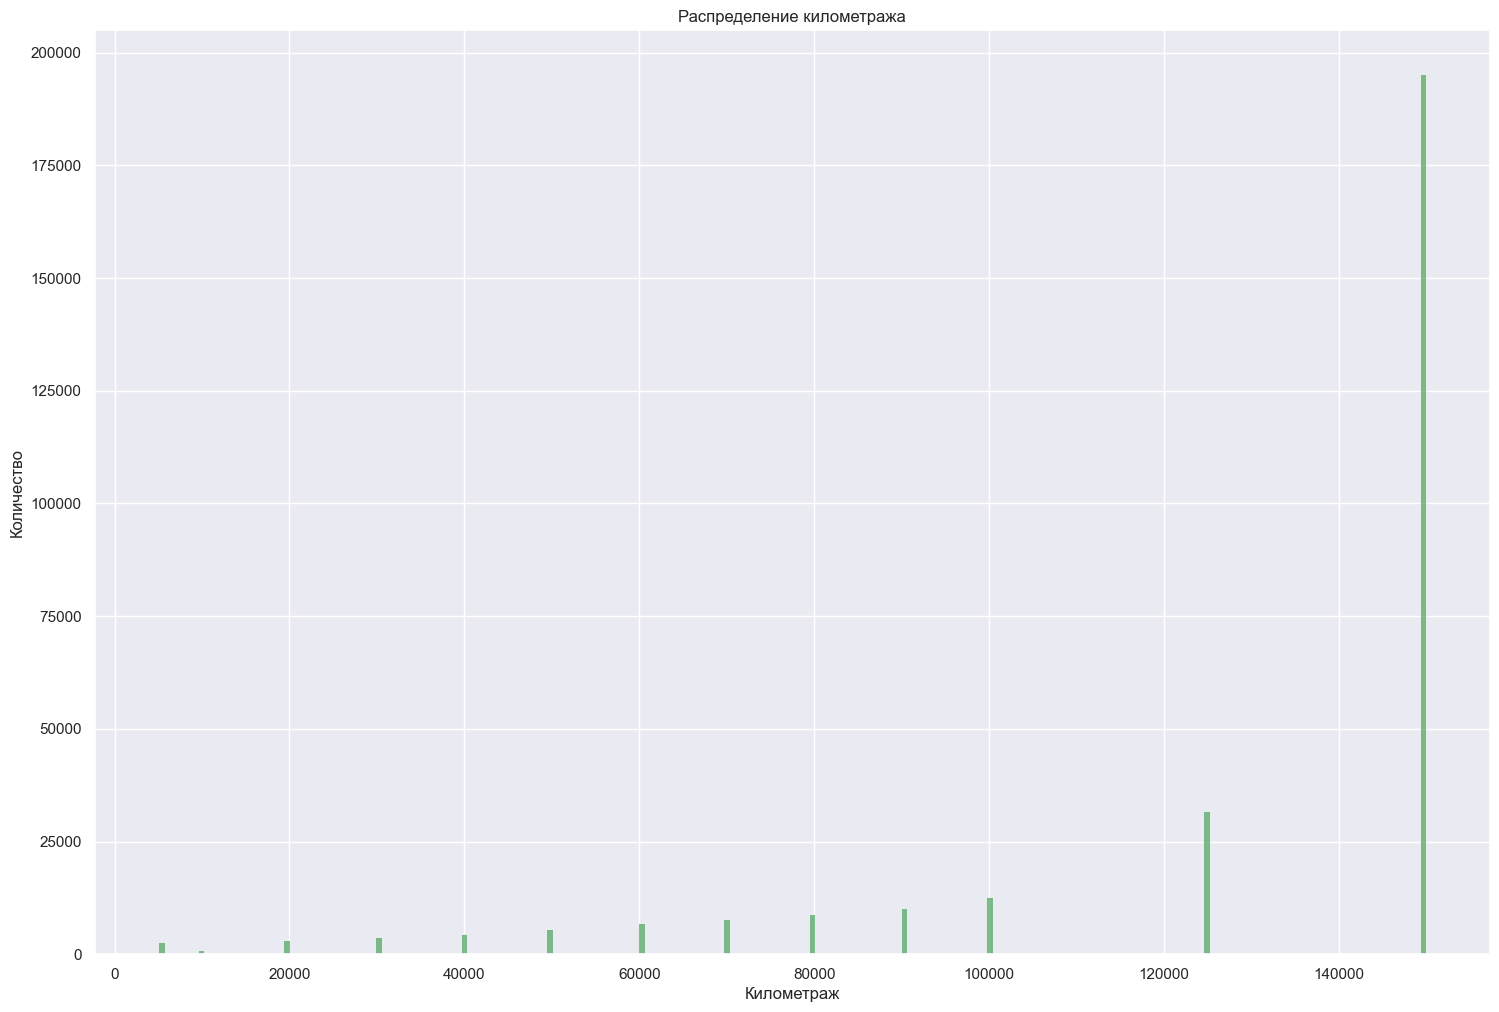

In [24]:
sns.set(rc={"figure.figsize": (18, 12)})
sns.histplot(data.Kilometer, color='g').set(title='Распределение километража', xlabel='Километраж', ylabel='Количество');

In [25]:
data.Kilometer.value_counts()

150000    195219
125000     31715
100000     12798
90000      10283
80000       9016
70000       7801
60000       6833
50000       5647
40000       4497
30000       3879
20000       3243
5000        2751
10000        914
Name: Kilometer, dtype: int64

Этот столбец может показаться странным, но вполне возможно, что он специально сделан, как выбор из списка, поэтому исправлять здесь ничего не будем.

- Столбец **месяц регистрации**

In [26]:
data.RegistrationMonth.value_counts()

3     30325
6     27465
4     25655
5     25519
7     23748
10    22893
12    21120
11    20987
9     20892
1     20074
8     19661
2     18790
0     17467
Name: RegistrationMonth, dtype: int64

Думаю с этим столбцом можно ничего не делать, так как потом я его вовсе удалю, думаю он не влияет на цену автомобиля

- Столбец **количетво картинок**

In [27]:
data.NumberOfPictures.value_counts()

0    294596
Name: NumberOfPictures, dtype: int64

В этом столбце все значения нулевые, значит его нужно удалить

In [28]:
data = data.drop('NumberOfPictures', axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294596 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        294596 non-null  object
 1   Price              294596 non-null  int64 
 2   VehicleType        294596 non-null  object
 3   RegistrationYear   294596 non-null  int64 
 4   Gearbox            294596 non-null  object
 5   Power              294596 non-null  int64 
 6   Model              294596 non-null  object
 7   Kilometer          294596 non-null  int64 
 8   RegistrationMonth  294596 non-null  int64 
 9   FuelType           294596 non-null  object
 10  Brand              294596 non-null  object
 11  Repaired           294596 non-null  object
 12  DateCreated        294596 non-null  object
 13  PostalCode         294596 non-null  int64 
 14  LastSeen           294596 non-null  object
dtypes: int64(6), object(9)
memory usage: 36.0+ MB


**Итог**

После работы с пропусками и аномалиями удалось сохранить максимальное число объектов

#### Отбор признаков

In [30]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

На мой взгляд на цену автомобиля не влияют DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen. Избавляемся от них

In [31]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

#### Удаление дубликатов

In [32]:
data.duplicated().sum()

45785

В даатсете 46000 дубликатов. От них необходимо избавиться

In [33]:
data.drop_duplicates().reset_index(drop=True)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
248806,5250,other,2016,auto,150,159,150000,other,alfa_romeo,no
248807,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
248808,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
248809,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


#### Кодирование категорильных признаков

In [34]:
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
data_OHE = pd.get_dummies(data, columns=cat)

enc = OrdinalEncoder()
data_OE = data.copy()
data_OE[cat] = enc.fit_transform(data_OE[cat])

#### Масштабирование числовых признаков

In [35]:
features = data.drop('Price', axis=1)
target = data['Price']

features_OHE = data_OHE.drop('Price', axis=1)
target_OHE = data_OHE['Price']

features_united_OHE, features_test_OHE, target_united_OHE, target_test_OHE = train_test_split(features_OHE, target_OHE, test_size=0.2, random_state=28) 
features_train_OHE, features_valid_OHE, target_train_OHE, target_valid_OHE = train_test_split(features_united_OHE, target_united_OHE, test_size=0.25, random_state=28)

features_OE = data_OE.drop('Price', axis=1)
target_OE = data_OE['Price']

features_united_OE, features_test_OE, target_united_OE, target_test_OE = train_test_split(features_OE, target_OE, test_size=0.2, random_state=28) 
features_train_OE, features_valid_OE, target_train_OE, target_valid_OE = train_test_split(features_united_OE, target_united_OE, test_size=0.25, random_state=28)

In [36]:
def scaler(data_train, data_test, data_valid):
    scaler = StandardScaler()
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = scaler.fit(data_train[numeric])
    features_train_scaled = scaler.transform(data_train[numeric])
    features_test_scaled = scaler.transform(data_test[numeric])
    features_valid_scaled = scaler.transform(data_valid[numeric])
    data_train[numeric] = features_train_scaled
    data_test[numeric] = features_test_scaled
    data_valid[numeric] = features_valid_scaled 
    return data_train, data_test, data_valid
    
features_train_OHE, features_test_OHE, features_valid_OHE = scaler(features_train_OHE, features_test_OHE, features_valid_OHE) 
features_train_OE, features_test_OE, features_valid_OE = scaler(features_train_OE, features_test_OE, features_valid_OE) 

#### Проверка на корреляцию

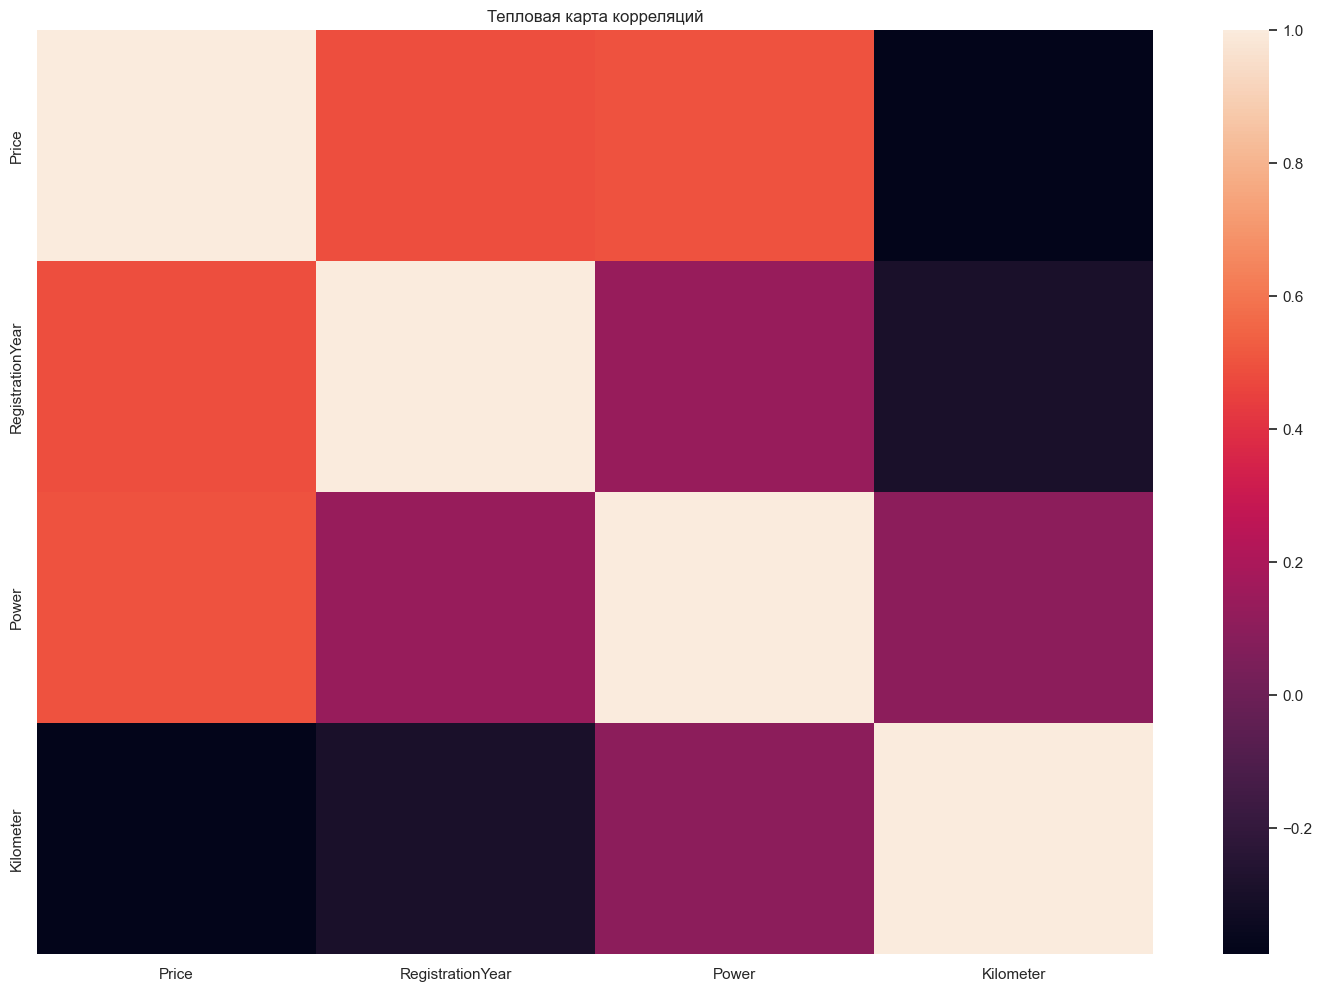

In [37]:
sns.heatmap(data.corr()).set(title='Тепловая карта корреляций');

Единственная внушительная корреляция(около 0.5) наблюдается между ценой и годом регистрации автомобиля. 

**Вывод**

По итогу предобработки проделаны важные этапы, данные очищены от пропусков и аномалий, удалены дубликаты, даннные масштабированы и кодированы, проверка на корреляцию пройдена.

## Обучение моделей

In [39]:
def rmse(vec, predict):
    return mean_squared_error(vec, predict)**0.5

### Решающее дерево 

In [41]:
model = DecisionTreeRegressor(random_state=28)
params = {'max_depth': range(1, 20, 5)}
grid_model = GridSearchCV(model, params, cv=3, scoring=make_scorer(rmse, greater_is_better=False), n_jobs=-1)
grid_model.fit(features_train_OE, target_train_OE)
print('Наилучшее значение RMSE достигается при глубине дерева', grid_model.best_params_['max_depth'])

Наилучшее значение RMSE достигается при глубине дерева 16


In [42]:
model = DecisionTreeRegressor(max_depth=16, min_samples_split=2, random_state=28)

start = time.time()
model.fit(features_train_OE, target_train_OE)
end = time.time()
fit_time_DTR = end - start
print('Время обучения решающего дерева:', fit_time_DTR)

start = time.time()
predicts = model.predict(features_train_OE)
end = time.time()
predict_time_DTR = end - start
print('Время предсказания решающего дерева:', predict_time_DTR)

rmse_DTR = grid_model.best_score_ * (-1)
print('Итоговая метрика решающего дерева:', rmse_DTR)

Время обучения решающего дерева: 0.5398540496826172
Время предсказания решающего дерева: 0.03699970245361328
Итоговая метрика решающего дерева: 1934.350110281349


### Случайный лес

In [43]:
model = RandomForestRegressor(random_state=28)
params = {'n_estimators': range(50, 151, 50), 'max_depth': range(5, 16, 5)}
grid_model = GridSearchCV(model, params, cv=3, scoring=make_scorer(rmse, greater_is_better=False), n_jobs=-1)
grid_model.fit(features_train_OE, target_train_OE)
print('Наилучшее значение RMSE достигается при глубине дерева', grid_model.best_params_['max_depth'], ' и количестве деревьев', grid_model.best_params_['n_estimators'])

Наилучшее значение RMSE достигается при глубине дерева 15  и количестве деревьев 150


In [44]:
model = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=28)

start = time.time()
model.fit(features_train_OE, target_train_OE)
end = time.time()
fit_time_RFR = end - start
print('Время обучения случайного леса:', fit_time_RFR)

start = time.time()
predicts = model.predict(features_train_OE)
end = time.time()
predict_time_RFR = end - start
print('Время предсказания случайного леса:', predict_time_RFR)

rmse_RFR = grid_model.best_score_ * (-1)
print('Итоговая метрика случайного леса:', rmse_RFR)

Время обучения случайного леса: 54.55139183998108
Время предсказания случайного леса: 4.57734489440918
Итоговая метрика случайного леса: 1653.6698413340137


### Линейная регрессия

In [45]:
model = LinearRegression()
params = {}
grid_model = GridSearchCV(model, params, cv=3, scoring=make_scorer(rmse, greater_is_better=False), n_jobs=-1)
grid_model.fit(features_train_OHE, target_train_OHE)
print('Наилучшее значение RMSE достигается при наличии сдвига:', grid_model.best_score_ * (-1))

Наилучшее значение RMSE достигается при наличии сдвига: 6684317120683.922


### LightGBM

In [46]:
minim = 5000
for j in range(100, 201, 50):
    for i in range(5, 16, 5):
        lgb_model = lgb.LGBMRegressor(
            objective = 'root_mean_squared_error',
            num_leaves = i,
            max_depth = j,
            random_state=28)
        lgb_model.fit(features_train_OE, target_train_OE)
        predicts = lgb_model.predict(features_valid_OE)
        if rmse(target_valid_OE, predicts) < minim:
            minim = rmse(target_valid_OE, predicts)
            best = [j, i]
print('Наилучшее значение RMSE достигается при глубине дерева', j, ' и количестве листьев', i)

Наилучшее значение RMSE достигается при глубине дерева 200  и количестве листьев 15


In [47]:
model = lgb.LGBMRegressor(
            objective = 'root_mean_squared_error',
            num_leaves = 15,
            max_depth = 200,
            random_state=28)

start = time.time()
model.fit(features_train_OE, target_train_OE)
end = time.time()
fit_time_LGBM = end - start
print('Время обучения LGBM:', fit_time_LGBM)

start = time.time()
predicts = model.predict(features_valid_OE)
end = time.time()
predict_time_LGBM = end - start
print('Время предсказания LGBM:', predict_time_LGBM)

rmse_LGBM = minim
print('Итоговая метрика LGBM:', rmse_LGBM)

Время обучения LGBM: 0.5230374336242676
Время предсказания LGBM: 0.09600639343261719
Итоговая метрика LGBM: 1774.9757372862646


### CatBoost

In [52]:
model = CatBoostRegressor(loss_function='RMSE')

pool_train = Pool(features_train_OE, target_train_OE)

grid = {'depth': [5, 10]}

grid_search_result = model.grid_search(grid, 
                                       pool_train,
                                       plot=False)

0:	learn: 6565.5088316	test: 6507.3252873	best: 6507.3252873 (0)	total: 166ms	remaining: 2m 46s
1:	learn: 6405.0526575	test: 6347.8933420	best: 6347.8933420 (1)	total: 179ms	remaining: 1m 29s
2:	learn: 6247.6906020	test: 6192.4387395	best: 6192.4387395 (2)	total: 194ms	remaining: 1m 4s
3:	learn: 6097.0588529	test: 6042.3776942	best: 6042.3776942 (3)	total: 206ms	remaining: 51.3s
4:	learn: 5952.6779808	test: 5898.6097135	best: 5898.6097135 (4)	total: 220ms	remaining: 43.7s
5:	learn: 5812.4279665	test: 5759.0665808	best: 5759.0665808 (5)	total: 237ms	remaining: 39.3s
6:	learn: 5676.4945992	test: 5624.0256377	best: 5624.0256377 (6)	total: 253ms	remaining: 35.9s
7:	learn: 5543.1778473	test: 5492.0632255	best: 5492.0632255 (7)	total: 266ms	remaining: 33s
8:	learn: 5416.0358403	test: 5365.5920569	best: 5365.5920569 (8)	total: 283ms	remaining: 31.2s
9:	learn: 5294.2244531	test: 5244.9438033	best: 5244.9438033 (9)	total: 300ms	remaining: 29.7s
10:	learn: 5174.4556605	test: 5126.7438770	best: 5

In [54]:
model = CatBoostRegressor(loss_function='RMSE', depth = 10)

start = time.time()
model.fit(pool_train)
end = time.time()
fit_time_CB = end - start
print('Время обучения CatBoost:', fit_time_CB)

start = time.time()
pool_test = Pool(features_valid_OE)
predicts = model.predict(pool_test)
end = time.time()
predict_time_CB = end - start
print('Время предсказания CatBoost:', predict_time_CB)

rmse_CB = rmse(target_valid_OE, predicts)
print('Итоговая метрика CatBoost:', rmse_CB)

Learning rate set to 0.09274
0:	learn: 4306.1971705	total: 44.5ms	remaining: 44.5s
1:	learn: 4029.2752925	total: 89.6ms	remaining: 44.7s
2:	learn: 3788.6986763	total: 131ms	remaining: 43.4s
3:	learn: 3568.6674725	total: 171ms	remaining: 42.7s
4:	learn: 3376.4168261	total: 210ms	remaining: 41.7s
5:	learn: 3204.4145952	total: 254ms	remaining: 42.1s
6:	learn: 3049.9871041	total: 299ms	remaining: 42.4s
7:	learn: 2912.9221581	total: 336ms	remaining: 41.7s
8:	learn: 2792.6986236	total: 374ms	remaining: 41.2s
9:	learn: 2688.1987092	total: 413ms	remaining: 40.9s
10:	learn: 2593.9534598	total: 454ms	remaining: 40.8s
11:	learn: 2511.7698748	total: 499ms	remaining: 41.1s
12:	learn: 2437.0309144	total: 544ms	remaining: 41.3s
13:	learn: 2370.3834705	total: 592ms	remaining: 41.7s
14:	learn: 2314.9387395	total: 630ms	remaining: 41.4s
15:	learn: 2265.9448751	total: 667ms	remaining: 41s
16:	learn: 2218.0145312	total: 707ms	remaining: 40.9s
17:	learn: 2177.3140072	total: 754ms	remaining: 41.1s
18:	learn

## Анализ моделей

In [55]:
data_models = pd.DataFrame({'Скорость обучения': [fit_time_DTR, fit_time_RFR, fit_time_LGBM, fit_time_CB], 
                            'Скорость предсказания': [predict_time_DTR, predict_time_RFR, predict_time_LGBM, predict_time_CB], 
                           'Точность': [rmse_DTR, rmse_RFR, rmse_LGBM, rmse_CB]},
                          index=['DTR', 'RFR', 'LGBM', 'CB'])
data_models

,Скорость обучения,Скорость предсказания,Точность
DTR,0.539854,0.037000,1934.350110
RFR,54.551392,4.577345,1653.669841
LGBM,0.523037,0.096006,1774.975737
CB,41.346227,0.167008,1542.575885


Из таблицы видно, что самым предпочтительным вариантом является LGBM. Несмотря на то, что он уступает CatBoost, скорость обучения у LGBM в 7 раз меньше. Именно поэтому выбираем LGBM.

In [57]:
model = lgb.LGBMRegressor(
            objective = 'root_mean_squared_error',
            num_leaves = 15,
            max_depth = 200,
            random_state=28)
model.fit(features_train_OE, target_train_OE)
predicts = model.predict(features_test_OE)
print('Итоговый RMSE на тестовой выборке составляет:', rmse(target_test_OE, predicts))

Итоговый RMSE на тестовой выборке составляет: 1740.0143031075938


**Вывод**

В конечном итоге опредлено, что, удовлетворяя требованиям заказчика, с данной задачей лучше всего справляется LGBM. Полученная метрика - 1740.